In this notebook, we will pick a dataset with 6 independent variables and do principal component analysis on the independent variables. Using the PCA results, we will reduce the dimensionality of the data set. Finally we will construct simple linear regression models with the original independent variables and contrast it against a model with the new reduced set of variables constructed using PCA

## Import Libraries

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data transformation
from scipy.stats import zscore

# Importing Linear_regression model:
from sklearn.linear_model import LinearRegression
    
# Importing PCA for dimensionality reduction:
from sklearn.decomposition import PCA

# Importing tree based and ensemble regression models from sklearn:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Importing the evaluation metrics from sklearn:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

%matplotlib inline

## Load and review data

In [4]:
cData = pd.read_csv("auto-mpg.csv")  
print(cData.shape)
print(cData.columns)

(398, 9)
Index(['mpg', 'cyl', 'disp', 'hp', 'wt', 'acc', 'yr', 'origin', 'car name'], dtype='object')


In [5]:
# Data description:

# 8 variables: 

# Target Variable:
    # MPG (miles per gallon)
    
# Independent variables:
# cylinders (number of engine cylinders)
# engine displacement (cu. inches), 
# horsepower,
# vehicle weight (lbs.), 
# time to accelerate from O to 60 mph (sec.),
# model year (modulo 100), and 
# origin of car (1. American, 2. European,3. Japanese).

# Also provided are the car labels (types) 
# Missing data values are marked by series of question marks.

cData.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [6]:
# Checking the information on the dataset:
cData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg         398 non-null float64
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
origin      398 non-null int64
car name    398 non-null object
dtypes: float64(3), int64(4), object(2)
memory usage: 24.9+ KB


In [8]:
# Checking for missing values in each of the columns in the dataset:
cData.isnull().sum()

mpg         0
cyl         0
disp        0
hp          0
wt          0
acc         0
yr          0
origin      0
car name    0
dtype: int64

In [10]:
cData.isna().sum()

mpg         0
cyl         0
disp        0
hp          0
wt          0
acc         0
yr          0
origin      0
car name    0
dtype: int64

In [13]:
# Observations: There are no missing values in the Dataset.

In [9]:
# Five point summary
cData.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mpg,398,NaN,NaN,NaN,23.5146,7.81598,9,17.5,23,29,46.6
cyl,398,NaN,NaN,NaN,5.45477,1.701,3,4,4,8,8
disp,398,NaN,NaN,NaN,193.426,104.27,68,104.25,148.5,262,455
hp,398,94,150,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wt,398,NaN,NaN,NaN,2970.42,846.842,1613,2223.75,2803.5,3608,5140
acc,398,NaN,NaN,NaN,15.5681,2.75769,8,13.825,15.5,17.175,24.8
yr,398,NaN,NaN,NaN,76.0101,3.69763,70,73,76,79,82
origin,398,NaN,NaN,NaN,1.57286,0.802055,1,1,1,2,3
car name,398,305,ford pinto,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since the focus is on the PCA technique, we will drop the non-numerica variables. Remember 'origin' is categorical.

In [11]:
#dropping/ignoring the independent attributes 'car_name'  and 'origin'
cData = cData.drop(['car name','origin'], axis=1)
cData.head()

,mpg,cyl,disp,hp,wt,acc,yr
0,18.0,8,307.0,130,3504,12.0,70
1,15.0,8,350.0,165,3693,11.5,70
2,18.0,8,318.0,150,3436,11.0,70
3,16.0,8,304.0,150,3433,12.0,70
4,17.0,8,302.0,140,3449,10.5,70


In [15]:
cData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 7 columns):
mpg     398 non-null float64
cyl     398 non-null int64
disp    398 non-null float64
hp      398 non-null object
wt      398 non-null int64
acc     398 non-null float64
yr      398 non-null int64
dtypes: float64(3), int64(3), object(1)
memory usage: 20.2+ KB


### Exploratory Data analysis: 

In [19]:
# There are about 6 datapoints in the column 'hp' that are '?'. Replace these values with median.

# isdigit()? on 'horsepower' 
hpIsDigit = pd.DataFrame(cData.hp.str.isdigit())  # if the string is made of digits store True else False

#print isDigit = False!
cData[hpIsDigit['hp'] == False]   # from temp take only those rows where hp has false

,mpg,cyl,disp,hp,wt,acc,yr
32,25.0,4,98.0,?,2046,19.0,71
126,21.0,6,200.0,?,2875,17.0,74
330,40.9,4,85.0,?,1835,17.3,80
336,23.6,4,140.0,?,2905,14.3,80
354,34.5,4,100.0,?,2320,15.8,81
374,23.0,4,151.0,?,3035,20.5,82


In [20]:
# The datapoints '?' in the column 'hp' has been replaced with 'nan'
cData = cData.replace('?', np.nan)
cData[hpIsDigit['hp'] == False]

,mpg,cyl,disp,hp,wt,acc,yr
32,25.0,4,98.0,NaN,2046,19.0,71
126,21.0,6,200.0,NaN,2875,17.0,74
330,40.9,4,85.0,NaN,1835,17.3,80
336,23.6,4,140.0,NaN,2905,14.3,80
354,34.5,4,100.0,NaN,2320,15.8,81
374,23.0,4,151.0,NaN,3035,20.5,82


There are various ways to handle missing values. Drop the rows, replace missing values with median values etc. of the 398 rows 6 have NAN in the hp column. We could drop those 6 rows - which might not be a good idea under all situations. Here, we will replace them with their median values. First replace '?' with NaN and then replace NaN with median


In [21]:
#instead of dropping the rows, lets replace the missing values with median value. 
cData.median()

mpg       23.0
cyl        4.0
disp     148.5
hp        93.5
wt      2803.5
acc       15.5
yr        76.0
dtype: float64

In [22]:
# replace the missing values with median value.
# Note, we do not need to specify the column names below
# every column's missing value is replaced with that column's median respectively  (axis =0 means columnwise)
#cData = cData.fillna(cData.median())

medianFiller = lambda x: x.fillna(x.median())
cData = cData.apply(medianFiller,axis=0)

cData['hp'] = cData['hp'].astype('float64')  # converting the hp column from object / string type to float

F:\Anaconda-Home\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
F:\Anaconda-Home\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
F:\Anaconda-Home\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
F:\Anaconda-Home\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
F:\Anaconda-Home\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is

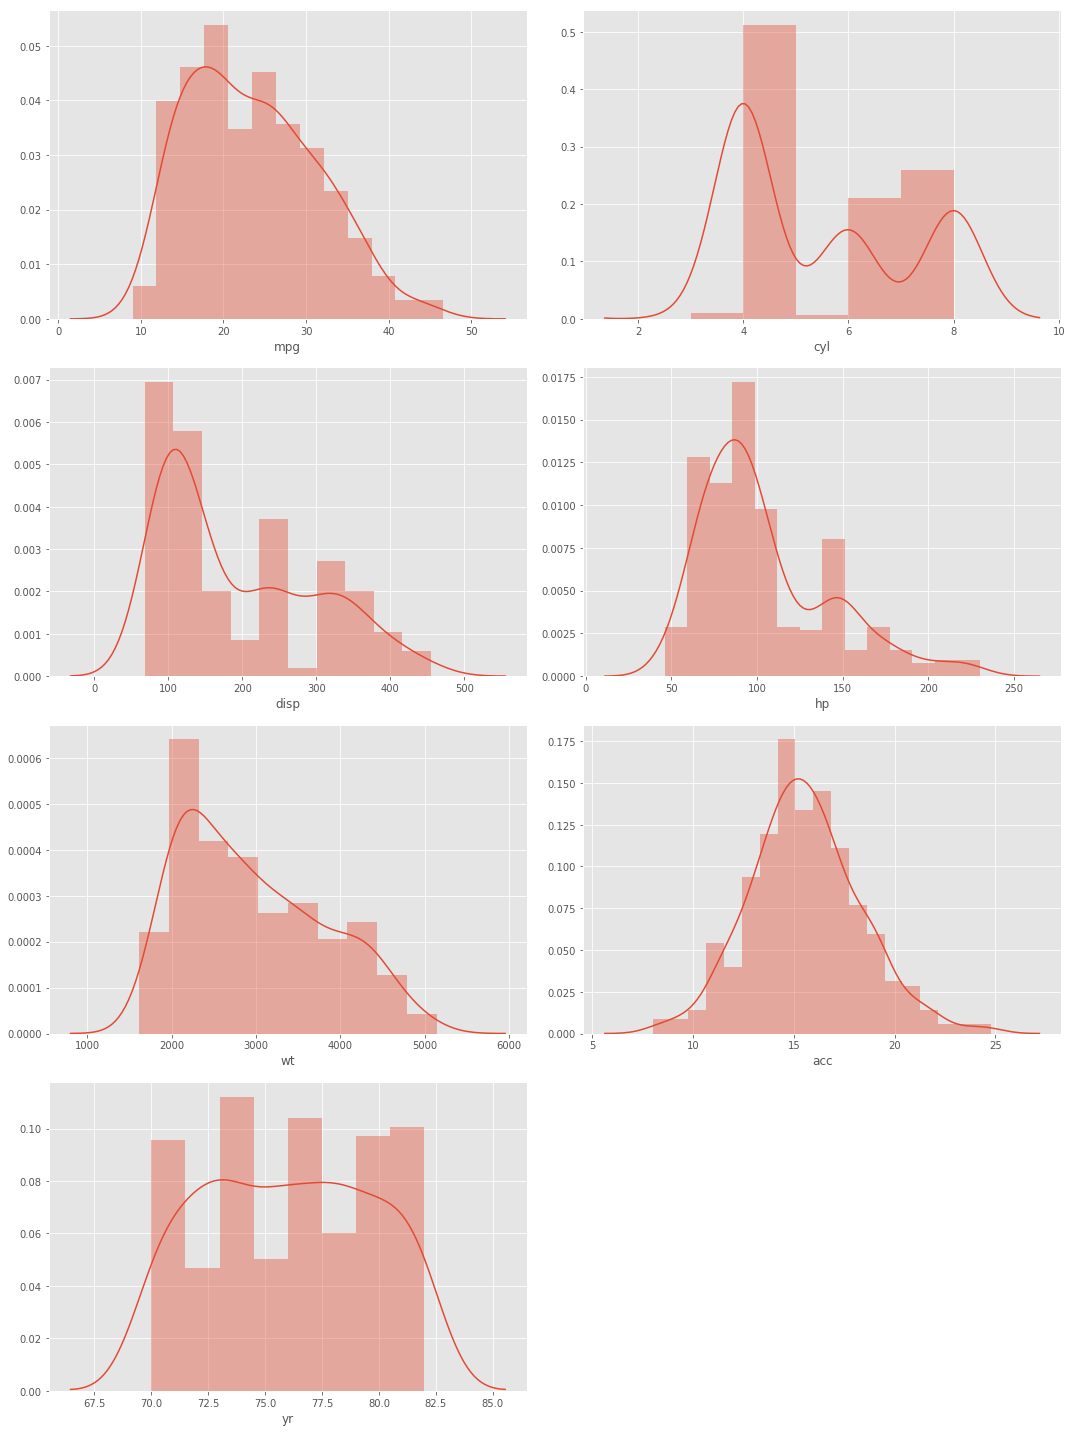

In [23]:
# Univariate analysis of independent attributes:

# Distribution plots (Histogram):

with plt.style.context('ggplot'):
    f, ax = plt.subplots(figsize=(15,20))
    for i,col in enumerate(cData.columns):
        plt.subplot(4,2,i+1)
        sns.distplot(cData[col],kde=True)
    plt.tight_layout()

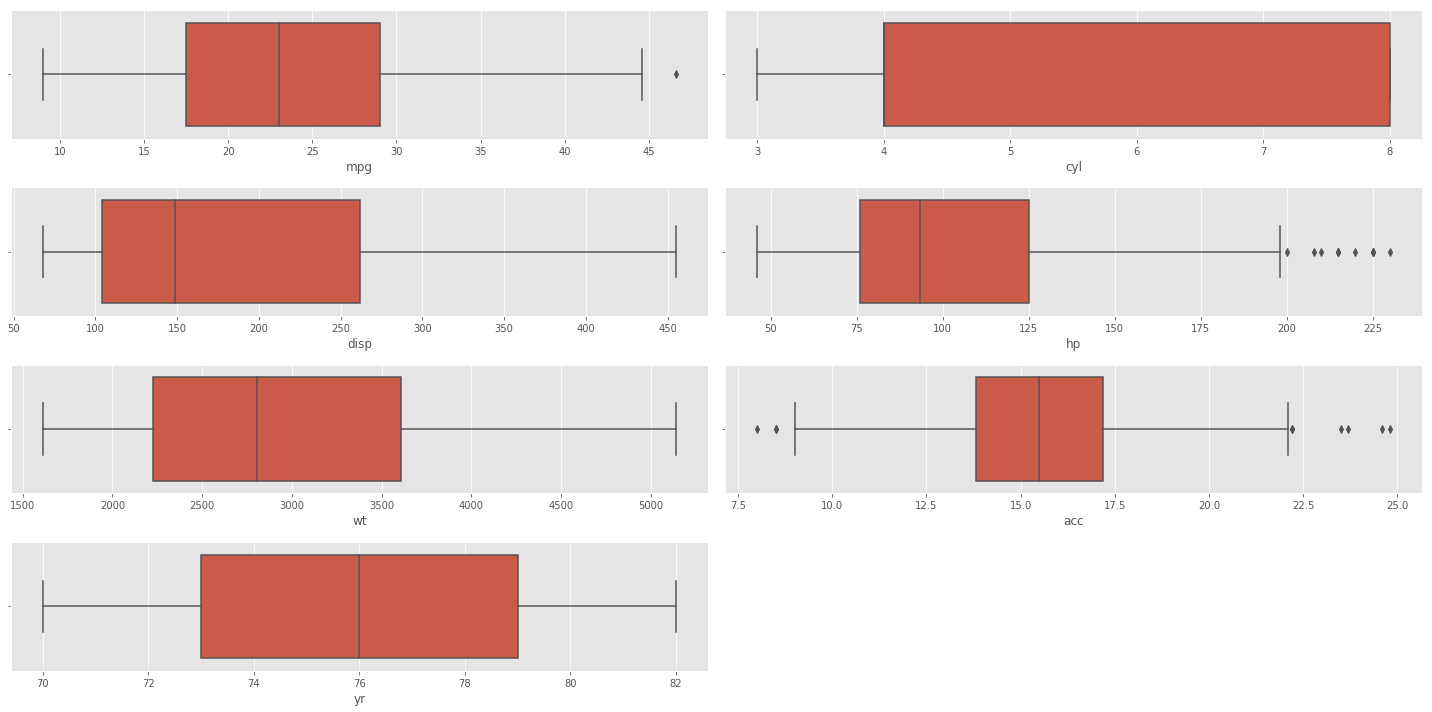

In [24]:
# Boxplots of all the attributes:

with plt.style.context('ggplot'):
    f, ax = plt.subplots(figsize=(20,10))
    for i,col in enumerate(cData.columns):
        plt.subplot(4,2,i+1)
        sns.boxplot(cData[col],notch=False,orient='h')
    plt.tight_layout()

In [25]:
# Observations:

# From the Box-plots it is evident that few columns have outliers: 'mpg','hp','acc'
# All the columns are continuous attributes except for the column 'Cyl'. it is a categorical variable.

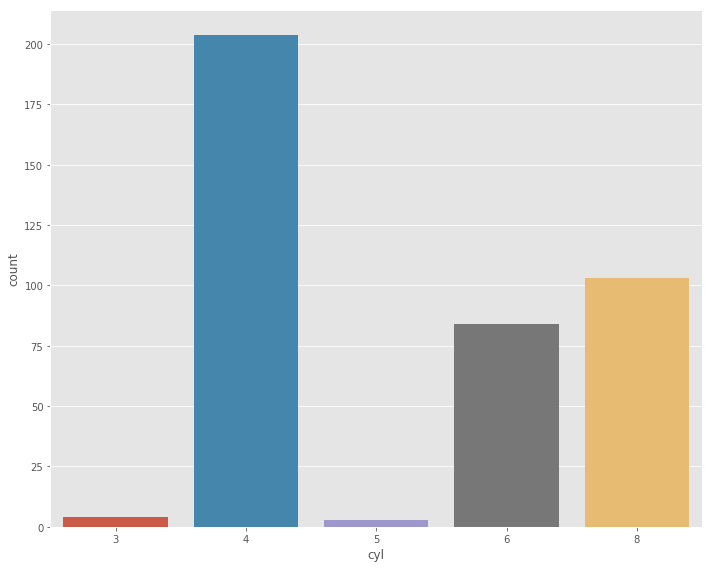

In [26]:
with plt.style.context('ggplot'):
    f, ax = plt.subplots(figsize=(10,8))
    sns.countplot(cData['cyl'])
    plt.tight_layout()

<Figure size 1080x1080 with 0 Axes>

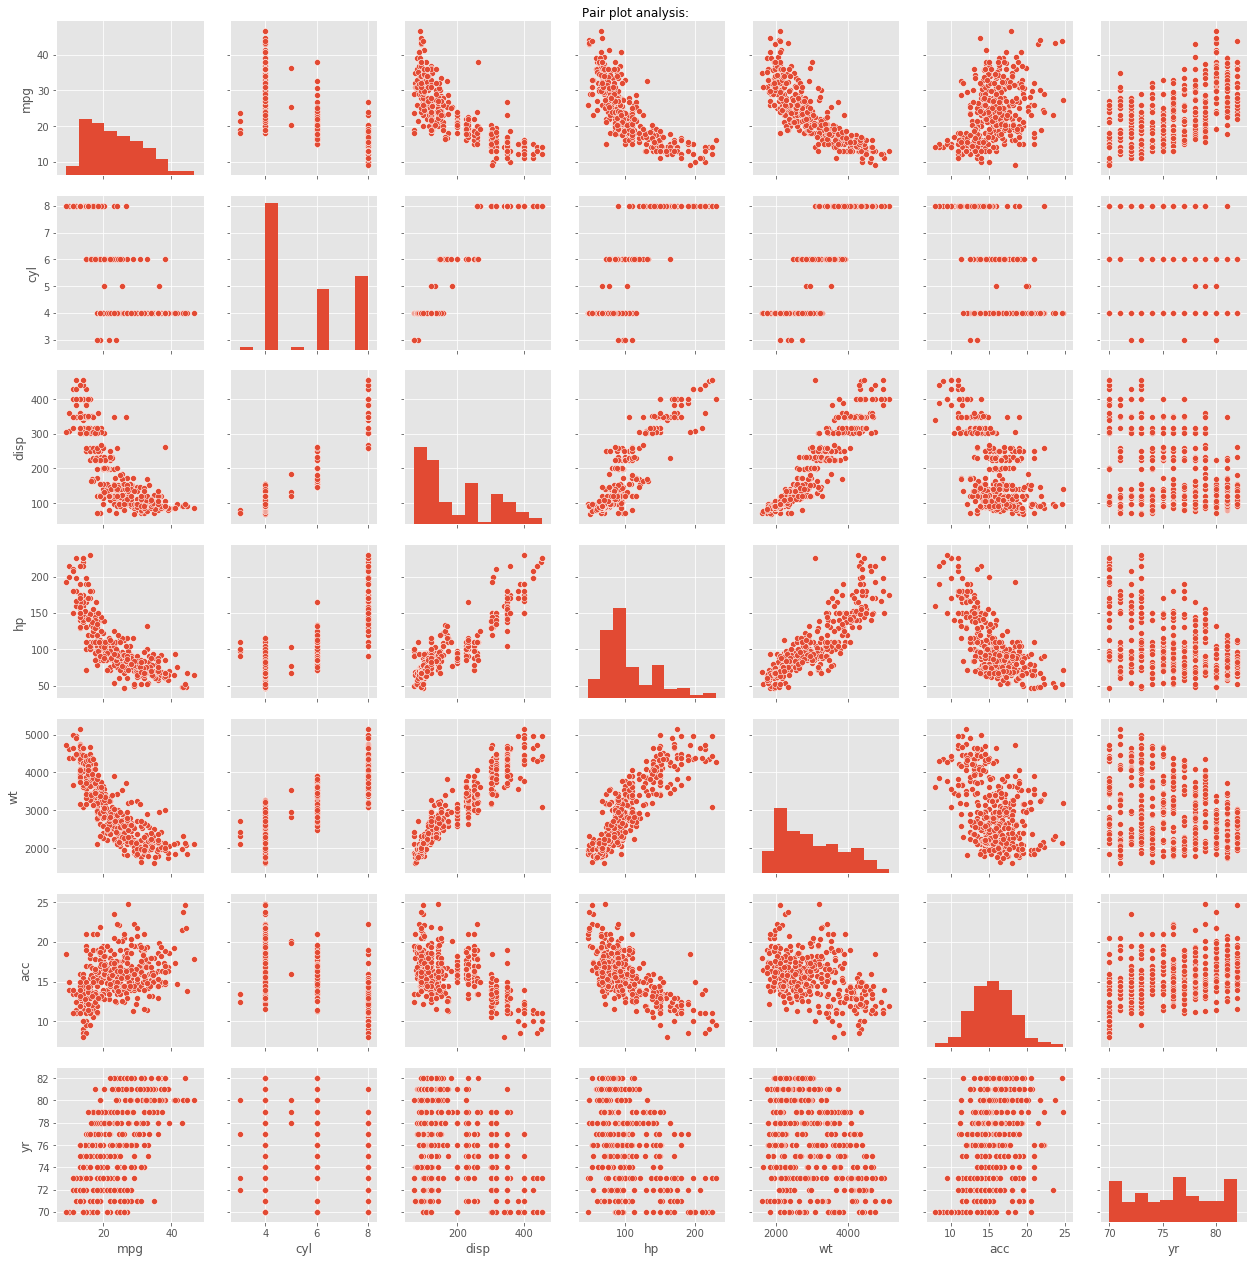

In [27]:
# Multivariate analysis:

# Pair plot analysis:

with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(15,15))
    sns_plot = sns.pairplot(cData,diag_kind='hist')
    plt.suptitle('Pair plot analysis:',x=0.5,y=1)
    plt.show()

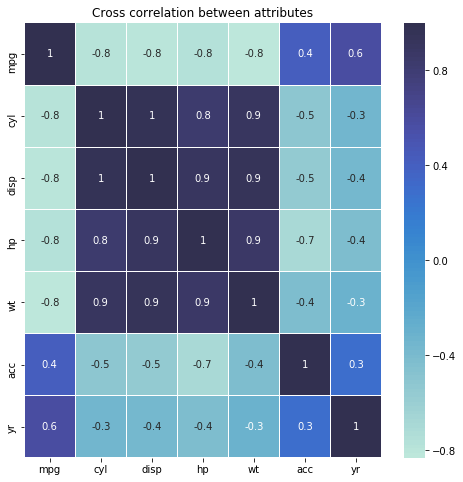

In [28]:
# Heat Map to represent correlation among attributes:

plt.figure(figsize=(8,8))
ax = sns.heatmap(cData.corr(), annot = True, fmt='.1g', linewidths = 0.01,center=1.5)
plt.title('Cross correlation between attributes')
plt.show()

In [29]:
# Observations:

# From the heatmap of correlation matrix, it is observed that the dataset has the issue of multicolliniarity.
# Most of the independent attributes are highly correlated to each other.

## BiVariate Plots

A bivariate analysis among the different independent variables can be done using scatter matrix plot. Seaborn libs create a dashboard reflecting useful information about the dimensions. The result can be stored as a .png file. 

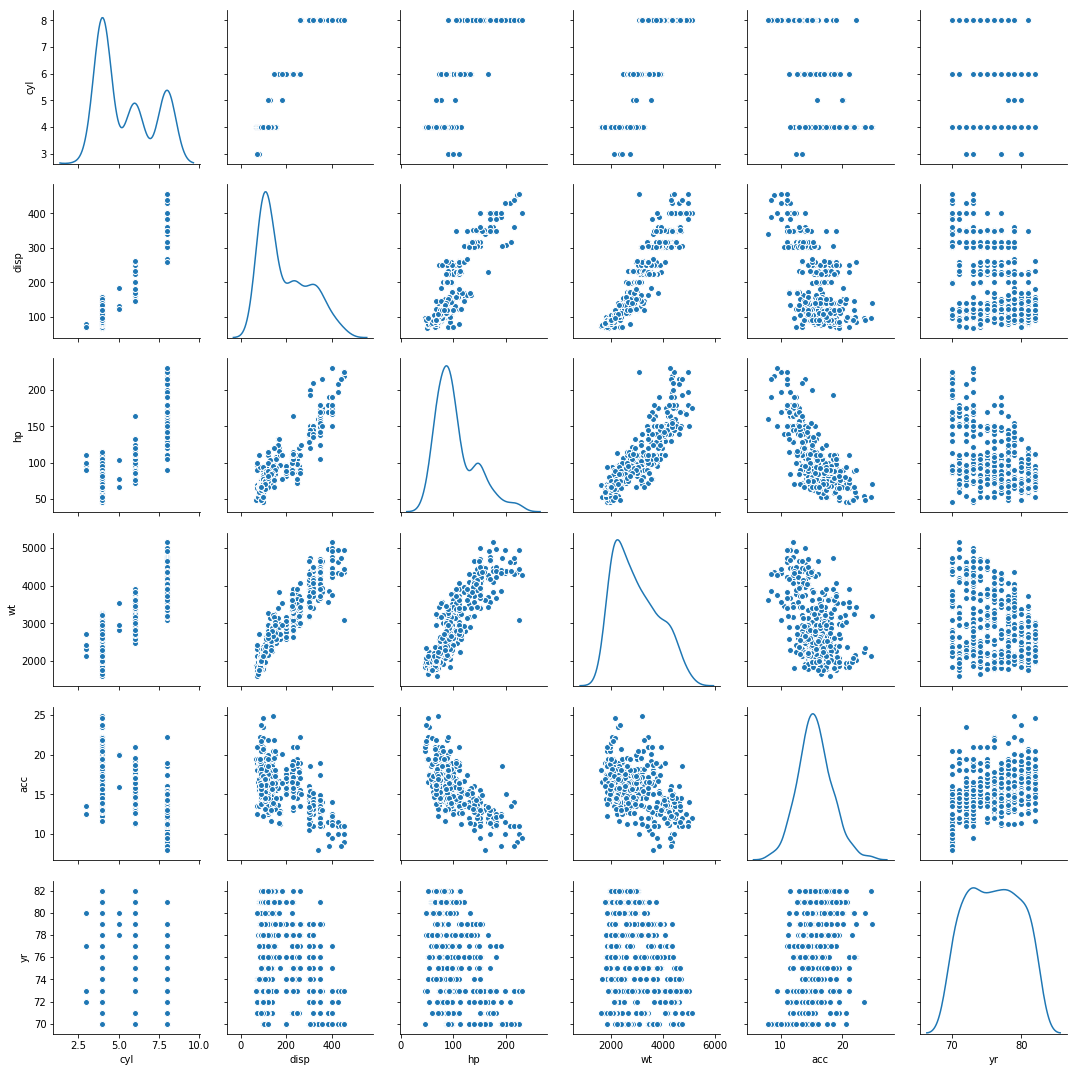

In [30]:
# independant variables
X = cData.drop(['mpg'], axis=1)
# the dependent variable
y = cData[['mpg']]

sns.pairplot(X, diag_kind='kde')   # to plot density curve instead of histogram on the diag

### PCA (Principal component analysis):

In [36]:
# Step1: Scaling the independent attributes. (z-score transformation)

XScaled=X.apply(zscore)
XScaled.head()

,cyl,disp,hp,wt,acc,yr
0,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426
1,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426
2,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426
3,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426
4,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426


In [37]:
# Step2: Computing the covariance matrix on the scaled dataset:

covMatrix = np.cov(XScaled,rowvar=False)
print(covMatrix)

[[ 1.00251889  0.95311615  0.84340357  0.89827376 -0.50669259 -0.34962425]
 [ 0.95311615  1.00251889  0.89803457  0.93517383 -0.54505356 -0.37109656]
 [ 0.84340357  0.89803457  1.00251889  0.86461476 -0.68831918 -0.41477495]
 [ 0.89827376  0.93517383  0.86461476  1.00251889 -0.41850885 -0.30733654]
 [-0.50669259 -0.54505356 -0.68831918 -0.41850885  1.00251889  0.28886274]
 [-0.34962425 -0.37109656 -0.41477495 -0.30733654  0.28886274  1.00251889]]


In [38]:
# Step3: Computing the eigen values and eigen vectors from the covariance matrix: using PCA from scikit learning

pca = PCA(n_components=6)
pca.fit(XScaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The eigen Values

In [39]:
# Eigen values:
print(pca.explained_variance_)

[4.26378678 0.84068225 0.67499578 0.13552589 0.06386533 0.03625731]


The eigen Vectors

In [39]:
# Eigen vectors:
print(pca.components_)

[[ 0.45509041  0.46913807  0.46318283  0.44618821 -0.32466834 -0.23188446]
 [ 0.18276349  0.16077095  0.0139189   0.25676595  0.21039209  0.9112425 ]
 [ 0.17104591  0.13443134 -0.12440857  0.27156481  0.86752316 -0.33294164]
 [-0.65709523 -0.18742114  0.62819714  0.33868744  0.15214558  0.02469974]
 [ 0.28804531 -0.00141408  0.60418441 -0.68887559  0.27061128  0.06487726]
 [-0.46420823  0.83717483 -0.10059817 -0.26829299  0.0367486   0.01405118]]


And the percentage of variation explained by each eigen Vector

In [40]:
# Explains the percentage of variation by each eigen vector:
print(pca.explained_variance_ratio_)

[0.70884563 0.13976166 0.11221664 0.0225309  0.01061748 0.0060277 ]


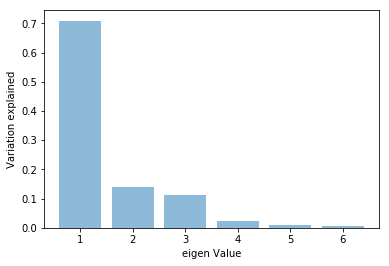

In [42]:
# The bar plot which explains the percentage of variation in the dataset by each eigen value:
plt.bar(list(range(1,7)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

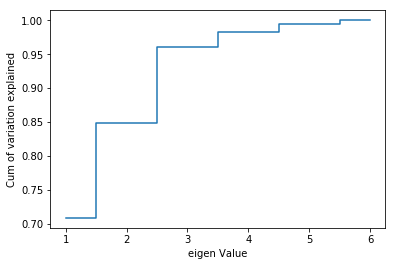

In [43]:
# The step plot which explains the cumulative sum of varaiance by each eigen value:
plt.step(list(range(1,7)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [44]:
# Observations:

# From both the 'barplot' and 'stepplot' it is evident that elbow is observed in the 3rd eigen value.
# Which means approximatley 96% of the variation in the dataset has been observed by top 3 principal components.

# Dimensionality Reduction

Now 3 dimensions seems very reasonable. With 3 variables we can explain over 95% of the variation in the original data!

In [46]:
# Building the principal components with top three eigen values.
pca3 = PCA(n_components=3)
pca3.fit(XScaled)

# Eigen vectors:
print('Pricipal components:',pca3.components_)

# Eigen values:
print('Eigen values:',pca3.explained_variance_)

# Variation in the dataset:
print('Percentage of variance explained:',pca3.explained_variance_ratio_)

# obtaining principal vectors by (dot product of eigen values and transformed scaled dataset)
Xpca3 = pca3.transform(XScaled)

Pricipal components: [[ 0.45509041  0.46913807  0.46318283  0.44618821 -0.32466834 -0.23188446]
 [ 0.18276349  0.16077095  0.0139189   0.25676595  0.21039209  0.9112425 ]
 [ 0.17104591  0.13443134 -0.12440857  0.27156481  0.86752316 -0.33294164]]
Eigen values: [4.26378678 0.84068225 0.67499578]
Percentage of variance explained: [0.70884563 0.13976166 0.11221664]


In [56]:
# Three principal components:
Xpca3

array([[ 2.58470158, -1.13503558, -0.09158558],
       [ 3.36172518, -1.03670689, -0.24694524],
       [ 2.95892839, -1.20779415, -0.47937758],
       ...,
       [-1.16393463,  0.71574676, -2.16248162],
       [-1.94324569,  1.32567228,  0.14526268],
       [-1.95553788,  1.41517409,  0.41668135]])

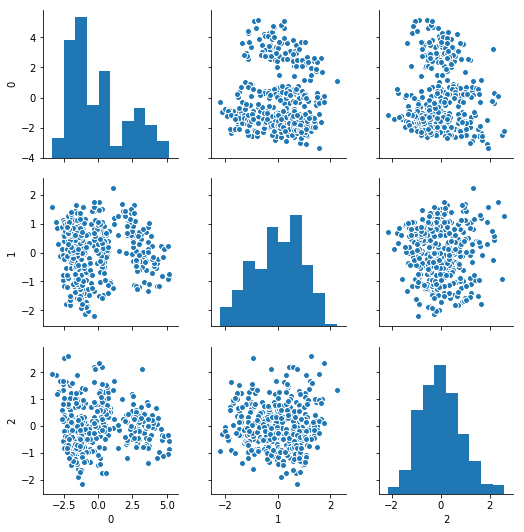

In [48]:
# Pairplot of new principal components:
sns.pairplot(pd.DataFrame(Xpca3))

In [53]:
PCA3 = pd.DataFrame(Xpca3)
PCA3.head()

,0,1,2
0,2.584702,-1.135036,-0.091586
1,3.361725,-1.036707,-0.246945
2,2.958928,-1.207794,-0.479378
3,2.776396,-1.153929,-0.183434
4,2.831315,-1.270389,-0.620758


In [52]:
print(PCA3.shape)

(398, 3)


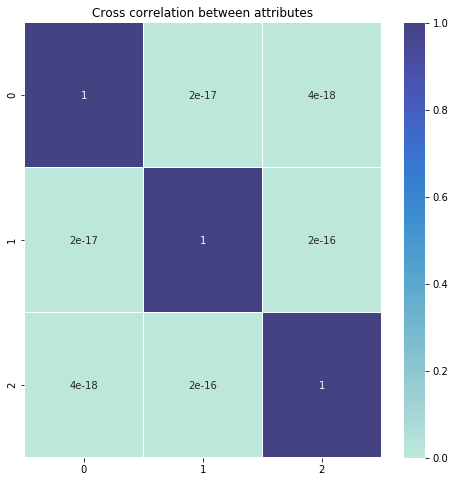

In [54]:
# Heat Map to represent correlation matrix among the 3 principal components:

plt.figure(figsize=(8,8))
ax = sns.heatmap(PCA3.corr(), annot = True, fmt='.1g', linewidths = 0.01,center=1.5)
plt.title('Cross correlation between attributes')
plt.show()

## Fit Linear Model

Lets construct two linear models. The first with all the 6 independent variables and the second with only the 3 new variables constructed using PCA.

In [55]:
# Fitting the Linear regression model on the entire dataset:
regression_model = LinearRegression()
regression_model.fit(XScaled, y)
regression_model.score(XScaled, y)

0.8087079552406331

In [56]:
# Fitting the Linear regression model on the 3 Principal components:
regression_model_pca = LinearRegression()
regression_model_pca.fit(Xpca3, y)
regression_model_pca.score(Xpca3, y)

0.7799909620572006

Looks like by drop reducing dimensionality by 3, we only dropped around 3% in R^2! This is insample (on training data) and hence a drop in R^2 is expected. Still seems easy to justify the dropping of variables. An out of sample (on test data), with the 3 independent variables is likely to do better since that would be less of an over-fit. 

### checking various regression Model performance:

In [61]:
# Splitting the original scaled dataset into train test split:
X_train,X_test,Y_train,Y_test = train_test_split(XScaled,y,test_size=0.2,random_state=10)
print(X_train.shape)
print(X_test.shape)

(318, 6)
(80, 6)


In [62]:
# Splitting the principal componets dataset into train test split:
X_train_pca,X_test_pca,Y_train_pca,Y_test_pca = train_test_split(PCA3,y,test_size=0.2,random_state=10)
print(X_train_pca.shape)
print(X_test_pca.shape)

(318, 3)
(80, 3)


LR: 0.810125 (0.027495)
DT: 0.790027 (0.047951)
RF: 0.858927 (0.036497)


F:\Anaconda-Home\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda-Home\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda-Home\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

BAG: 0.867094 (0.037238)


F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ADA: 0.854687 (0.027714)
GB: 0.875882 (0.022106)


F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


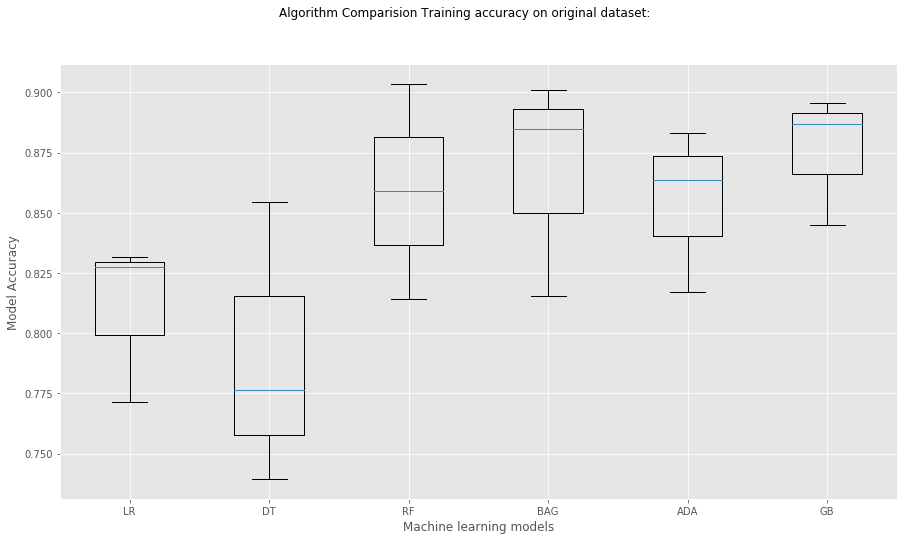

In [65]:
# Baseline model comparisions with 3 fold cross-validation on original scaled dataset:

models = []

models.append(('LR',LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('BAG',BaggingRegressor()))
models.append(('ADA',AdaBoostRegressor()))
models.append(('GB',GradientBoostingRegressor()))

# evaluate each model in turn

results = []
names = []
scoring = 'accuracy'

for name, model in models:
	kfold = KFold(n_splits=3, random_state=10)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
    
# boxplot algorithm comparison
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(15,8))
    fig.suptitle('Algorithm Comparision Training accuracy on original dataset:')
    ax = fig.add_subplot(111)
    ax.set(xlabel='Machine learning models', ylabel='Model Accuracy')
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

LR: 0.658160 (0.110737)
DT: 0.347243 (0.479585)
RF: 0.667219 (0.133489)


F:\Anaconda-Home\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda-Home\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda-Home\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

BAG: 0.722906 (0.075221)


F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

ADA: 0.621644 (0.195651)
GB: 0.712108 (0.180441)


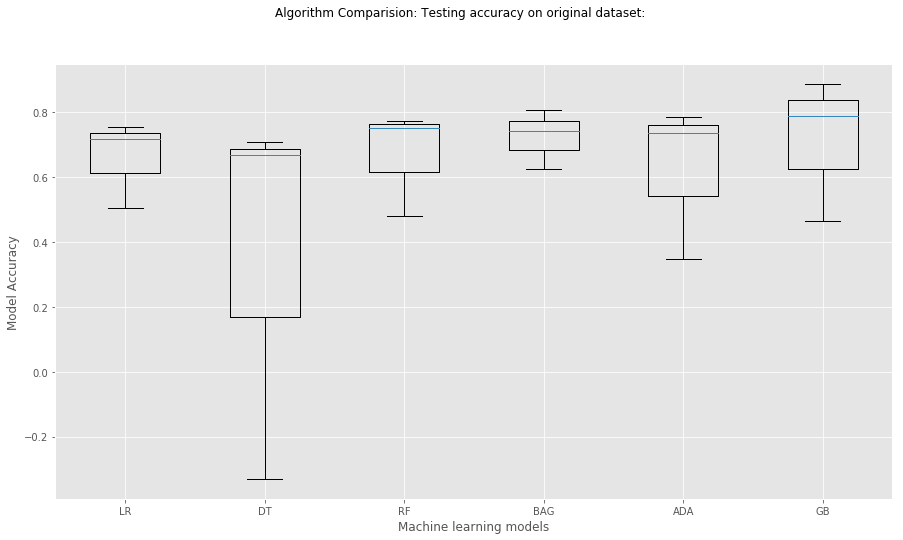

In [66]:
# Baseline model comparisions with 3 fold cross-validation on original scaled dataset:

models = []

models.append(('LR',LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('BAG',BaggingRegressor()))
models.append(('ADA',AdaBoostRegressor()))
models.append(('GB',GradientBoostingRegressor()))

# evaluate each model in turn

results = []
names = []
scoring = 'accuracy'

for name, model in models:
	kfold = KFold(n_splits=3, random_state=10)
	cv_results = cross_val_score(model, X_test, Y_test, cv=kfold)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
    
# boxplot algorithm comparison
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(15,8))
    fig.suptitle('Algorithm Comparision: Testing accuracy on original dataset:')
    ax = fig.add_subplot(111)
    ax.set(xlabel='Machine learning models', ylabel='Model Accuracy')
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

LR: 0.781416 (0.035812)
DT: 0.750746 (0.012287)


F:\Anaconda-Home\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda-Home\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda-Home\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

RF: 0.830219 (0.041306)
BAG: 0.844701 (0.037115)


F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

ADA: 0.833957 (0.054202)
GB: 0.857510 (0.032030)


F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


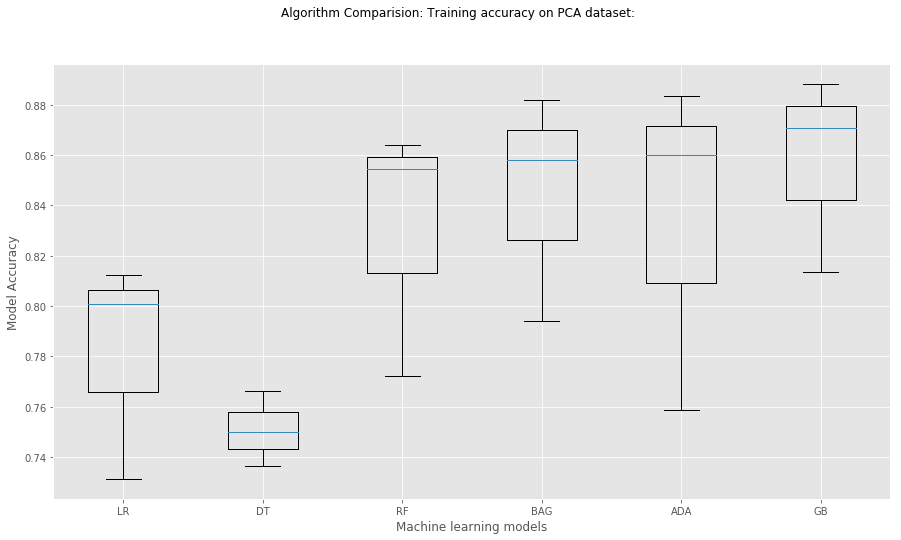

In [67]:
# Baseline model comparisions with 3 fold cross-validation on principal component dataset:

models = []

models.append(('LR',LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('BAG',BaggingRegressor()))
models.append(('ADA',AdaBoostRegressor()))
models.append(('GB',GradientBoostingRegressor()))

# evaluate each model in turn

results = []
names = []
scoring = 'accuracy'

for name, model in models:
	kfold = KFold(n_splits=3, random_state=10)
	cv_results = cross_val_score(model, X_train_pca, Y_train_pca, cv=kfold)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
    
# boxplot algorithm comparison
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(15,8))
    fig.suptitle('Algorithm Comparision: Training accuracy on PCA dataset:')
    ax = fig.add_subplot(111)
    ax.set(xlabel='Machine learning models', ylabel='Model Accuracy')
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

LR: 0.680133 (0.116418)
DT: 0.646536 (0.212120)
RF: 0.692090 (0.156078)
BAG: 0.682042 (0.151380)


F:\Anaconda-Home\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda-Home\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda-Home\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

ADA: 0.700766 (0.120853)
GB: 0.714243 (0.106533)


F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda-Home\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


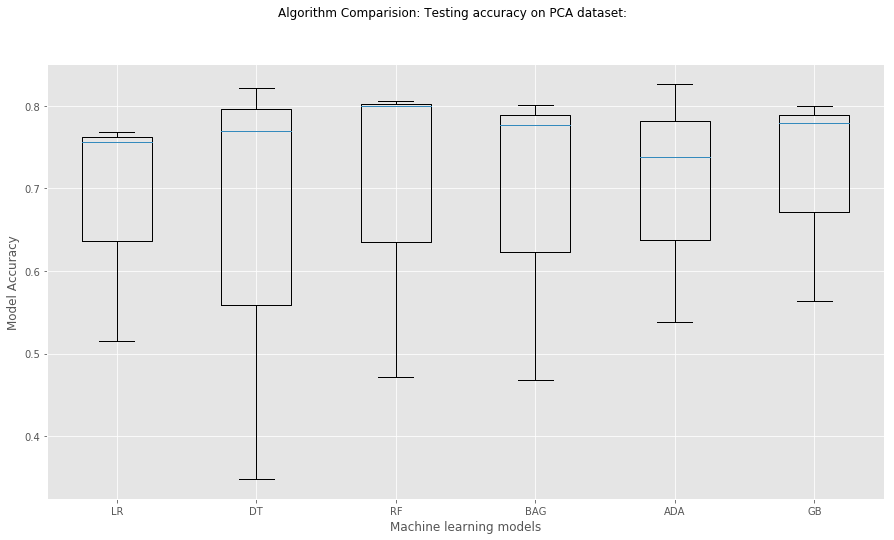

In [69]:
# Baseline model comparisions with 3 fold cross-validation on principal component dataset:

models = []

models.append(('LR',LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('BAG',BaggingRegressor()))
models.append(('ADA',AdaBoostRegressor()))
models.append(('GB',GradientBoostingRegressor()))

# evaluate each model in turn

results = []
names = []
scoring = 'accuracy'

for name, model in models:
	kfold = KFold(n_splits=3, random_state=10)
	cv_results = cross_val_score(model, X_test_pca, Y_test_pca, cv=kfold)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
    
# boxplot algorithm comparison
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(15,8))
    fig.suptitle('Algorithm Comparision: Testing accuracy on PCA dataset:')
    ax = fig.add_subplot(111)
    ax.set(xlabel='Machine learning models', ylabel='Model Accuracy')
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [70]:
# Observations:

# Looks like by drop reducing dimensionality by 3, we only dropped around 3% in R^2! This is insample 
# (on training data) and hence a drop in R^2 is expected. Still seems easy to justify the dropping of variables.
# An out of sample (on test data), with the 3 independent variables is likely to do better since that would be less of 
# an over-fit.